<a href="https://colab.research.google.com/github/CamilleKoSzePui/DL_as2/blob/main/cifar10_resnet50_adam_lr_0_0001_more_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RUN FIRST

In [ ]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import time 

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Preview one of the images..
def show_image(img, label):
    plt.figure(figsize=(1,1))
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

In [ ]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def acc_and_loss(model,loader,opt):

        model.eval()
        losses = []
        acc_lst = []
        mean_loss,acc = 0,0
        lbl_sz =0
        # criterion = cpt
        optimizer = opt
        #NO gradient required as not training
        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                # get the inputs
                inputs, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = model(inputs)
                #Accuracy
                lbl_sz+=labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                itm = (predicted == labels).sum().item()
                acc_lst.append(itm)
                #losses
                loss = F.cross_entropy(outputs, labels)
                losses.append(loss.item())
        mean_loss = np.mean(losses)
        acc=(100 * np.sum(acc_lst) / lbl_sz)
        return  acc,mean_loss

def fit_A(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam): #this works
  n_total_steps = len(train_loader)
  train_stats = []
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          # origin shape: [4, 3, 32, 32] = 4, 3, 1024
          # input_layer: 3 input channels, 6 output channels, 5 kernel size
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = F.cross_entropy(outputs, labels)

          # Backward and optimize
          opt_func.zero_grad()
          loss.backward()
          opt_func.step()

          if (i+1) % 2000 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      train_acc,train_loss = acc_and_loss(model,train_loader,opt_func)
      val_acc,val_loss = acc_and_loss(model,val_loader,opt_func)

      train_stat = {"epoch" : epoch+1,"train_loss" :train_loss,"train_acc" :train_acc,"val_acc": val_acc,"val_loss":val_loss}
      print(train_stat)
      train_stats.append(train_stat)
      model.train_stats = train_stats
  print('Finished Training')

def show_graph(epochs,model):
   train_accuracies = [x['train_acc'] for x in model.train_stats]
   val_accuracies = [x['val_acc'] for x in model.train_stats]  
   train_losses = [x['train_loss'] for x in model.train_stats]
   val_losses = [x['val_loss'] for x in model.train_stats] 
   print(train_accuracies)
   
   plt.figure(figsize=(5, 4))
   plt.title("Plotting Training/Validation Loss vs Epochs")
   plt.plot(np.arange(epochs), val_losses, label = "Validation Loss")
   plt.plot(np.arange(epochs), train_losses, label = "Training Loss")
   plt.legend()
   plt.show()
   
   plt.figure(figsize=(5, 4))
   plt.title("Plotting Training/Validation Accuracy  vs Epochs")
   plt.plot(np.arange(epochs), val_accuracies, label = "Validation Accuracy")
   plt.plot(np.arange(epochs), train_accuracies, label = "Training Accuracy")
   plt.legend()
   plt.show()

def acc_by_class(batch_size,model, val_loader):
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(10)]
      n_class_samples = [0 for i in range(10)]
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # max returns (value ,index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          
          for i in range(batch_size):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network: {acc} %')

      for i in range(10):
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes[i]}: {acc} %')

# Experiment 0

In [ ]:
# Model print

# resnet_weights = ResNet18_Weights.DEFAULT
resnet_weights = ResNet50_Weights.DEFAULT
resnet_transforms = resnet_weights.transforms()
print(resnet_transforms)
# model = resnet18(weights=resnet_transforms, progress=True)
model = resnet50(weights=resnet_transforms, progress=True)
model.fc = nn.Linear(2048, 10) 
model.to(device)
print(model)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentu

In [ ]:
# Checking the dataset training size.
dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=resnet_transforms)

print('Size of training dataset :', len(dataset))

Files already downloaded and verified
Size of training dataset : 50000


In [ ]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(42500, 2500, 5000)

In [ ]:
batch_size = 32 #change batch_size
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
classes = dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
img, label = dataset[100]
print(img.shape)

input_size = 3*224*224
output_size = 10

torch.Size([3, 224, 224])


In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 20
lr = 0.0001 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#


5000


In [ ]:
start = time.time()
fit_A(num_epochs, lr, model, train_loader, val_loader, optimizer)
print(time.time()-start)

{'epoch': 1, 'train_loss': 0.12657515285221302, 'train_acc': 96.05411764705882, 'val_acc': 92.36, 'val_loss': 0.21782626344857714}
{'epoch': 2, 'train_loss': 0.12131486047375345, 'train_acc': 95.91058823529411, 'val_acc': 92.32, 'val_loss': 0.23231721573945466}
{'epoch': 3, 'train_loss': 0.10603754111049533, 'train_acc': 96.35058823529411, 'val_acc': 91.68, 'val_loss': 0.24636232048933265}
{'epoch': 4, 'train_loss': 0.15251151632280716, 'train_acc': 94.70588235294117, 'val_acc': 89.2, 'val_loss': 0.3564205799322528}
{'epoch': 5, 'train_loss': 0.08901794941358666, 'train_acc': 97.04235294117647, 'val_acc': 92.36, 'val_loss': 0.24376519251897744}
{'epoch': 6, 'train_loss': 0.14077023304689223, 'train_acc': 95.32941176470588, 'val_acc': 89.52, 'val_loss': 0.3471903912280981}
{'epoch': 7, 'train_loss': 0.09833846629665659, 'train_acc': 96.64, 'val_acc': 90.96, 'val_loss': 0.3204819473542591}
{'epoch': 8, 'train_loss': 0.0584399886517344, 'train_acc': 98.08470588235294, 'val_acc': 92.64, 'v

[96.05411764705882, 95.91058823529411, 96.35058823529411, 94.70588235294117, 97.04235294117647, 95.32941176470588, 96.64, 98.08470588235294, 97.58588235294117, 96.11764705882354, 98.23529411764706, 99.14117647058823, 97.80941176470589, 99.22117647058823, 99.34588235294117, 98.6564705882353, 98.27058823529411, 99.3529411764706, 98.93176470588236, 97.72705882352942]


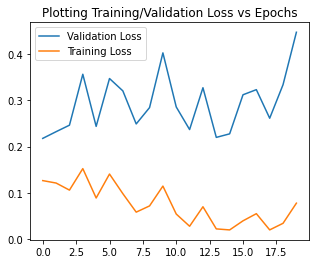

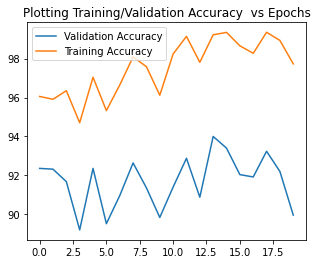

In [ ]:
show_graph(num_epochs,model)

In [ ]:
# acc_by_class(batch_size,model, val_loader)

##FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2022-10-26 05:17:48--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... failed: Connection refused.
mv: cannot stat 'download': No such file or directory


In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = len(classes)
model = resnet50(weights=resnet_transforms, progress=True)
print_model_parm_flops(model, input, detail=False)

ModuleNotFoundError: ignored